# Exploring and Modeling NYC Yellow Taxi Data — 2019 Edition

## Introduction

The New York City Taxi and Limousine Commission (NYC TLC) collects detailed trip records for all yellow taxi rides in the city. These records include information such as pickup and dropoff times, trip distances, passenger counts, and fare amounts. This dataset provides a valuable opportunity to explore travel patterns in New York City and to build predictive models for taxi fares.

In this project, the goal is to **predict taxi fare amounts** using trip-related features. The workflow follows a typical data science pipeline:

- **Data exploration (EDA):** Understanding the structure of the dataset, checking distributions, and identifying missing values and outliers.  
- **Data cleaning & preprocessing:** Handling missing data, removing or capping extreme outliers (e.g., capping fares at \$65.50 and identifying fixed rates such as the \$52 JFK fare).  
- **Feature engineering:** Creating new variables such as trip duration, mean distance, mean duration, and rush-hour indicators.  
- **Modeling:** Building and evaluating a multiple linear regression model to predict `fare_amount`.  
- **Evaluation:** Assessing performance with metrics such as R², MAE, MSE, and RMSE, and validating assumptions through residual plots.  

The findings show that features such as **mean_distance** and **mean_duration** are strongly correlated with fares and provide high predictive power. The regression model achieves strong accuracy, explaining over 86% of the variance in fare amounts, with relatively low error margins.

This notebook demonstrates an end-to-end machine learning workflow: from raw taxi trip records to a predictive model, providing both analytical insights and practical modeling results.



# Build a multiple linear regression model




##  **Plan**




### Task 1. Imports and loading


In [1]:
# Imports
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations
from datetime import datetime
from datetime import date
from datetime import timedelta

# Packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [7]:
# Load the data

url_2019 = "https://data.cityofnewyork.us/resource/2upf-qytp.csv?$limit=500000"
df0 = pd.read_csv(url_2019)
df0.head()



,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-01-01T00:46:40.000,2019-01-01T00:53:20.000,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95,NaN
1,1,2019-01-01T00:59:47.000,2019-01-01T01:18:59.000,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30,NaN
2,2,2018-12-21T13:48:30.000,2018-12-21T13:52:40.000,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN
3,2,2018-11-28T15:52:25.000,2018-11-28T15:55:45.000,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55,NaN
4,2,2018-11-28T15:56:57.000,2018-11-28T15:58:33.000,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55,NaN




1.   Outliers and extreme data values can significantly impact linear regression equations. After visualizing data, make a plan for addressing outliers by dropping rows, substituting extreme data with average data, and/or removing data values greater than 3 standard deviations.

2.   EDA activities also include identifying missing data to help the analyst make decisions on their exclusion or inclusion by substituting values with data set means, medians, and other similar methods.

3.   It's important to check for things like multicollinearity between predictor variables, as well to understand their distributions, as this will help you decide what statistical inferences can be made from the model and which ones cannot.

4.  Additionally, it can be useful to engineer new features by multiplying variables together or taking the difference from one variable to another. For example, in this dataset you can create a `duration` variable by subtracting `tpep_dropoff` from `tpep_pickup time`.

### Task 2a. Explore data with EDA



Start with `.shape` and `.info()`.

In [ ]:
df = df0.copy()

print(df.shape)

df.info()

(500000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vendorid               500000 non-null  int64  
 1   tpep_pickup_datetime   500000 non-null  object 
 2   tpep_dropoff_datetime  500000 non-null  object 
 3   passenger_count        500000 non-null  int64  
 4   trip_distance          500000 non-null  float64
 5   ratecodeid             500000 non-null  int64  
 6   store_and_fwd_flag     500000 non-null  object 
 7   pulocationid           500000 non-null  int64  
 8   dolocationid           500000 non-null  int64  
 9   payment_type           500000 non-null  int64  
 10  fare_amount            500000 non-null  float64
 11  extra                  500000 non-null  float64
 12  mta_tax                500000 non-null  float64
 13  tip_amount             500000 non-null  float64
 14  tolls_amount           

Check for missing data and duplicates using `.isna()` and `.drop_duplicates()`.

In [9]:
# Check for duplicates
print('Shape of dataframe:', df.shape)
print('Shape of dataframe with duplicates dropped:', df.drop_duplicates().shape)

# Check for missing values in dataframe
print('Total count of missing values:', df.isna().sum().sum())

# Display missing values per column in dataframe
print('Missing values per column:')
df.isna().sum()

Shape of dataframe: (500000, 18)
Shape of dataframe with duplicates dropped: (500000, 18)
Total count of missing values: 499999
Missing values per column:


vendorid                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count               0
trip_distance                 0
ratecodeid                    0
store_and_fwd_flag            0
pulocationid                  0
dolocationid                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     499999
dtype: int64

In [ ]:
df.drop(['congestion_surcharge'], axis=1, inplace=True)


In [12]:
df.isna().sum()

vendorid                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
ratecodeid               0
store_and_fwd_flag       0
pulocationid             0
dolocationid             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

Use `.describe()`.

In [13]:
# Display descriptive stats about the data
df.describe()

,vendorid,passenger_count,trip_distance,ratecodeid,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.652808,1.626444,3.265616,1.077832,161.757406,160.017508,1.376600,13.304562,0.264227,0.495658,1.723005,0.405424,0.299182,16.497292
std,0.546950,1.258209,4.265718,0.762734,67.031560,71.357954,0.506072,52.991489,0.463040,0.051905,2.711426,1.927026,0.021210,53.719995
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-300.000000,-4.500000,-0.500000,-2.490000,-21.000000,-0.300000,-300.300000
25%,1.000000,1.000000,0.990000,1.000000,114.000000,107.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.150000
50%,2.000000,1.000000,1.700000,1.000000,161.000000,162.000000,1.000000,9.000000,0.000000,0.500000,1.150000,0.000000,0.300000,11.160000
75%,2.000000,2.000000,3.320000,1.000000,232.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.160000,0.000000,0.300000,17.290000
max,4.000000,8.000000,128.730000,99.000000,265.000000,265.000000,4.000000,25356.380000,18.500000,0.500000,400.000000,576.000000,0.300000,25356.380000


 Some things stand out from this table of summary statistics. For instance, there are clearly some outliers in several variables, like `tip_amount` (\$200) and `total_amount` (\$576). Also, a number of the variables, such as `mta_tax`, seem to be almost constant throughout the data, which would imply that they would not be expected to be very predictive.

### Task 2b. Convert pickup & dropoff columns to datetime

In [14]:
# Check the format of the data
df['tpep_dropoff_datetime'][0]

'2019-01-01T00:53:20.000'

In [17]:
# Convert datetime columns to datetime
# Display data types of `tpep_pickup_datetime`, `tpep_dropoff_datetime`
print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

# Convert `tpep_pickup_datetime` to datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Convert `tpep_dropoff_datetime` to datetime format
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Display data types of `tpep_pickup_datetime`, `tpep_dropoff_datetime`
print('Data type of tpep_pickup_datetime:', df['tpep_pickup_datetime'].dtype)
print('Data type of tpep_dropoff_datetime:', df['tpep_dropoff_datetime'].dtype)

df.head()

Data type of tpep_pickup_datetime: datetime64[ns]
Data type of tpep_dropoff_datetime: datetime64[ns]
Data type of tpep_pickup_datetime: datetime64[ns]
Data type of tpep_dropoff_datetime: datetime64[ns]


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,7.0,0.5,0.5,1.65,0.0,0.3,9.95
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,14.0,0.5,0.5,1.00,0.0,0.3,16.30
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,4.5,0.5,0.5,0.00,0.0,0.3,5.80
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,7.55
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,52.0,0.0,0.5,0.00,0.0,0.3,55.55


### Task 2c. Create duration column

In [18]:
# Create `duration` column
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime'])/np.timedelta64(1,'m')


### Outliers



In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   vendorid               500000 non-null  int64         
 1   tpep_pickup_datetime   500000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  500000 non-null  datetime64[ns]
 3   passenger_count        500000 non-null  int64         
 4   trip_distance          500000 non-null  float64       
 5   ratecodeid             500000 non-null  int64         
 6   store_and_fwd_flag     500000 non-null  object        
 7   pulocationid           500000 non-null  int64         
 8   dolocationid           500000 non-null  int64         
 9   payment_type           500000 non-null  int64         
 10  fare_amount            500000 non-null  float64       
 11  extra                  500000 non-null  float64       
 12  mta_tax                500000 non-null  floa

### Task 2d. Box plots

Plot a box plot for each feature: `trip_distance`, `fare_amount`, `duration`.

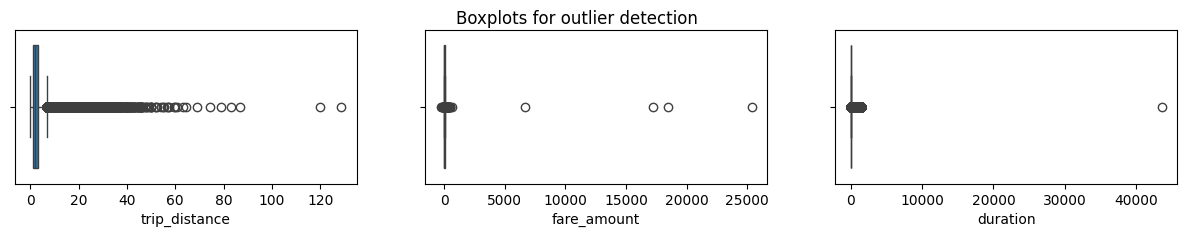

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df['trip_distance'])
sns.boxplot(ax=axes[1], x=df['fare_amount'])
sns.boxplot(ax=axes[2], x=df['duration'])
plt.show();


All three variables (trip_distance, fare_amount, and duration) display clear outliers. While some extreme values may represent unusual but valid trips, others are likely errors or rare events.

Considering that most NYC taxi rides occur within relatively short ranges, the majority of values cluster near the lower end. For trip_distance, extremely long trips above ~30–40 miles are unlikely within the city and may be outliers. For fare_amount and duration, the very high values are less realistic and more problematic, suggesting data quality issues.

Therefore, it may be acceptable to retain moderate outliers for trip_distance, but for fare_amount and duration it would be safer to cap or remove the extreme values to avoid skewing the model.

### Task 2e. Imputations

#### `trip_distance` outliers


In [21]:
# Are trip distances of 0 bad data or very short trips rounded down?
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]



Calculate the count of rides where the `trip_distance` is zero.

In [22]:
sum(df['trip_distance']==0)

4345

Note: Out of ~500,000 rides, 4,345 have a trip_distance equal to 0. This is a very small fraction of the dataset. One option would be to impute these values with a small number such as 0.01, but this adjustment is unlikely to meaningfully impact the model. Therefore, the trip_distance column will be left as is with respect to these cases.

In [23]:
df['fare_amount'].describe()

count    500000.000000
mean         13.304562
std          52.991489
min        -300.000000
25%           6.000000
50%           9.000000
75%          14.500000
max       25356.380000
Name: fare_amount, dtype: float64

Note: The histogram shows that most fares are concentrated at lower values, with the majority under $20. However, there are a few extreme cases with very high fares that stretch the distribution far to the right. These rare but unrealistic values likely represent data entry errors or anomalies. For modeling purposes, it will be important to filter or cap these outliers so they do not distort the regression results.

In [94]:
# Impute values less than $0 with 0
df.loc[df['fare_amount'] < 0, 'fare_amount'] = 0
float(df['fare_amount'].min())

0.0

Now impute the maximum value as `Q3 + (6 * IQR)`.

In [25]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    for col in column_list:
        # Reassign minimum to zero
        df.loc[df[col] < 0, col] = 0

        # Calculate upper threshold
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)

        # Reassign values > threshold to threshold
        df.loc[df[col] > upper_threshold, col] = upper_threshold
        print(df[col].describe())
        print()

In [26]:
outlier_imputer(['fare_amount'], 6)

fare_amount
q3: 14.5
upper_threshold: 65.5
count    500000.000000
mean         13.080137
std          11.769767
min           0.000000
25%           6.000000
50%           9.000000
75%          14.500000
max          65.500000
Name: fare_amount, dtype: float64



#### `duration` outliers

In [27]:
df['duration'].describe()

count    500000.000000
mean         17.093884
std          99.719671
min           0.000000
25%           5.850000
50%           9.883333
75%          16.400000
max       43648.016667
Name: duration, dtype: float64

The `duration` column has problematic values at both the lower and upper extremities.

* **Low values:** There should be no values that represent negative time. Impute all negative durations with `0`.

* **High values:** Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [28]:
# Impute a 0 for any negative values
df.loc[df['duration'] < 0, 'duration'] = 0
df['duration'].min()

np.float64(0.0)

In [29]:
# Impute the high outliers
outlier_imputer(['duration'], 6)

duration
q3: 16.4
upper_threshold: 79.69999999999999
count    500000.000000
mean         12.808819
std          10.525647
min           0.000000
25%           5.850000
50%           9.883333
75%          16.400000
max          79.700000
Name: duration, dtype: float64



### Task 3a. Feature engineering

#### Create `mean_distance` column



In this step, I created a column called `mean_distance` that captures the mean distance for each group of trips that share pickup and dropoff points.




In [ ]:
# Create `pickup_dropoff` column
df['pickup_dropoff'] = df['pulocationid'].astype(str) + ' ' + df['dolocationid'].astype(str)
df['pickup_dropoff'].head(2)

0    151 239
1    239 246
Name: pickup_dropoff, dtype: object

In [32]:
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['trip_distance']]
grouped[:5]

,trip_distance
pickup_dropoff,
1 1,2.272941
1 132,41.280000
1 142,18.730000
1 264,0.000000
1 265,10.285000


In [33]:
# 1. Convert `grouped` to a dictionary
grouped_dict = grouped.to_dict()

# 2. Reassign to only contain the inner dictionary
grouped_dict = grouped_dict['trip_distance']

In [35]:
# 1. Create a mean_distance column that is a copy of the pickup_dropoff helper column
df['mean_distance'] = df['pickup_dropoff']

# 2. Map `grouped_dict` to the `mean_distance` column
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# Confirm that it worked
df[(df['pulocationid']==100) & (df['dolocationid']==231)][['mean_distance']]

,mean_distance
15212,3.50129
20231,3.50129
56944,3.50129
63132,3.50129
63393,3.50129
...,...
475484,3.50129
476129,3.50129
476772,3.50129
482691,3.50129


#### Create `mean_duration` column

Repeat the process used to create the `mean_distance` column to create a `mean_duration` column.

In [ ]:
grouped = df.groupby('pickup_dropoff').mean(numeric_only=True)[['duration']]
grouped

# mean trip duration for all trips with those pickup_dropoff combos
grouped_dict = grouped.to_dict()
grouped_dict = grouped_dict['duration']

df['mean_duration'] = df['pickup_dropoff']
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# Confirm that it worked
df[(df['pulocationid']==100) & (df['dolocationid']==231)][['mean_duration']]

,mean_duration
15212,17.163306
20231,17.163306
56944,17.163306
63132,17.163306
63393,17.163306
...,...
475484,17.163306
476129,17.163306
476772,17.163306
482691,17.163306


#### Create `day` and `month` columns



In [38]:
# Create 'day' col
df['day'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()

# Create 'month' col
df['month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

#### Create `rush_hour` column

Define rush hour as:
* Any weekday (not Saturday or Sunday) AND
* Either from 06:00&ndash;10:00 or from 16:00&ndash;20:00



In [39]:
# Create 'rush_hour' col
df['rush_hour'] = df['tpep_pickup_datetime'].dt.hour

# If day is Saturday or Sunday, impute 0 in `rush_hour` column
df.loc[df['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

In [40]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [46]:
# Apply the `rush_hourizer()` function to the new column
df['rush_hour'] = df.apply(rush_hourizer, axis=1).astype(int)


df.loc[(df['day'] == 'saturday') | (df['day'] == 'sunday'), 'rush_hour'] = 0

df.head()


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
0,1,2019-01-01 00:46:40,2019-01-01 00:53:20,1,1.5,1,N,151,239,1,...,0.0,0.3,9.95,6.666667,151 239,1.203791,6.289080,tuesday,jan,0
1,1,2019-01-01 00:59:47,2019-01-01 01:18:59,1,2.6,1,N,239,246,1,...,0.0,0.3,16.30,19.200000,239 246,2.933402,11.947595,tuesday,jan,0
2,2,2018-12-21 13:48:30,2018-12-21 13:52:40,3,0.0,1,N,236,236,1,...,0.0,0.3,5.80,4.166667,236 236,0.579473,3.854176,friday,dec,0
3,2,2018-11-28 15:52:25,2018-11-28 15:55:45,5,0.0,1,N,193,193,2,...,0.0,0.3,7.55,3.333333,193 193,0.286634,2.696370,wednesday,nov,0
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.0,2,N,193,193,2,...,0.0,0.3,55.55,1.600000,193 193,0.286634,2.696370,wednesday,nov,0


### Task 4. Scatter plot


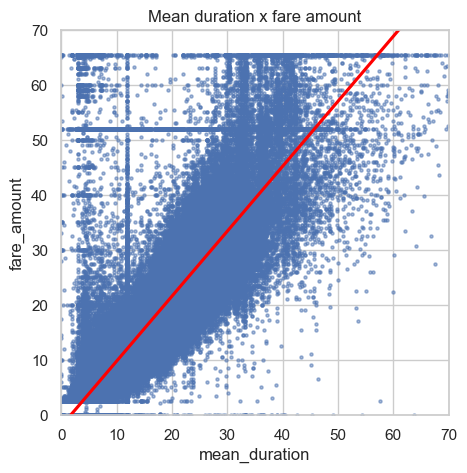

In [47]:
# Create a scatter plot of duration and trip_distance, with a line of best fit
sns.set(style='whitegrid')
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
sns.regplot(x=df['mean_duration'], y=df['fare_amount'],
            scatter_kws={'alpha':0.5, 's':5},
            line_kws={'color':'red'})
plt.ylim(0, 70)
plt.xlim(0, 70)
plt.title('Mean duration x fare amount')
plt.show()

Note: The scatter plot shows two clear horizontal lines.

The upper line corresponds to the maximum capped fare of $65.50, which was applied to all former outliers.

The second line appears around $52.00, which indicates that multiple rides in the dataset have exactly this fare amount. This is likely a common fixed fare (for example, standard airport trips), rather than an error.

In [48]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    16263
65.5     2285
60.0      200
65.0      155
51.0      147
Name: count, dtype: int64



Examine the first 30 of these trips.

In [49]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df[df['fare_amount']==52].head(30)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,day,month,rush_hour
4,2,2018-11-28 15:56:57,2018-11-28 15:58:33,5,0.00,2,N,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55,1.600000,193 193,0.286634,2.696370,wednesday,nov,0
6,2,2018-11-28 16:29:37,2018-11-28 16:33:43,5,0.00,2,N,193,193,2,52.0,0.0,0.5,0.00,0.00,0.3,55.55,4.100000,193 193,0.286634,2.696370,wednesday,nov,0
32,2,2019-01-01 00:43:28,2019-01-01 00:49:42,1,1.03,2,N,238,239,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,6.233333,238 239,0.796672,4.494216,tuesday,jan,0
33,2,2019-01-01 00:08:20,2019-01-01 00:41:51,2,19.13,2,N,132,238,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,33.516667,132 238,20.338672,39.773859,tuesday,jan,0
68,2,2019-01-01 00:35:25,2019-01-01 01:14:21,1,18.15,2,N,132,224,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,38.933333,132 224,18.465698,36.092829,tuesday,jan,0
70,1,2019-01-01 00:04:06,2019-01-01 00:38:55,4,18.10,2,N,132,224,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,34.816667,132 224,18.465698,36.092829,tuesday,jan,0
132,2,2019-01-01 00:39:58,2019-01-01 01:42:57,2,20.01,2,N,132,50,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,62.983333,132 50,19.107059,45.650980,tuesday,jan,0
141,2,2019-01-01 00:11:27,2019-01-01 00:46:29,5,21.42,2,N,132,87,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,35.033333,132 87,20.684064,42.956061,tuesday,jan,0
206,2,2019-01-01 00:36:48,2019-01-01 01:03:11,1,19.16,2,N,132,236,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,26.383333,132 236,19.232821,35.480769,tuesday,jan,0
228,1,2019-01-01 00:00:50,2019-01-01 00:31:48,0,18.00,2,N,132,140,1,52.0,0.0,0.5,7.00,0.00,0.3,59.80,30.966667,132 140,19.012526,34.781014,tuesday,jan,0




It seems that almost all of the trips in the first 30 rows where the fare amount was \$52 either begin or end at location 132, and all of them have a `RatecodeID` of 2.

There is no readily apparent reason why PULocation 132 should have so many fares of 52 dollars. They seem to occur on all different days, at different times, with both vendors, in all months. However, there are many toll amounts of $5.76 and \\$5.54. This would seem to indicate that location 132 is in an area that frequently requires tolls to get to and from. It's likely this is an airport.


The data dictionary says that `RatecodeID` of 2 indicates trips for JFK, which is John F. Kennedy International Airport. A quick Google search for "new york city taxi flat rate \$52" indicates that in 2017 (the year that this data was collected) there was indeed a flat fare for taxi trips between JFK airport (in Queens) and Manhattan.

Because `RatecodeID` is known from the data dictionary, the values for this rate code can be imputed back into the data after the model makes its predictions. This way you know that those data points will always be correct.

### Task 5. Isolate modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   vendorid               500000 non-null  int64         
 1   tpep_pickup_datetime   500000 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  500000 non-null  datetime64[ns]
 3   passenger_count        500000 non-null  int64         
 4   trip_distance          500000 non-null  float64       
 5   ratecodeid             500000 non-null  int64         
 6   store_and_fwd_flag     500000 non-null  object        
 7   pulocationid           500000 non-null  int64         
 8   dolocationid           500000 non-null  int64         
 9   payment_type           500000 non-null  int64         
 10  fare_amount            500000 non-null  float64       
 11  extra                  500000 non-null  float64       
 12  mta_tax                500000 non-null  floa

In [52]:
df2 = df.copy()

df2 = df2.drop([
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'trip_distance',
    'ratecodeid',
    'store_and_fwd_flag',
    'pulocationid',
    'dolocationid',
    'payment_type',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge',
    'total_amount',
    'pickup_dropoff',
    'day',
    'month'
], axis=1)

df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   vendorid         500000 non-null  int64  
 1   passenger_count  500000 non-null  int64  
 2   fare_amount      500000 non-null  float64
 3   duration         500000 non-null  float64
 4   mean_distance    500000 non-null  float64
 5   mean_duration    500000 non-null  float64
 6   rush_hour        500000 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 26.7 MB


### Task 6. Pair plot



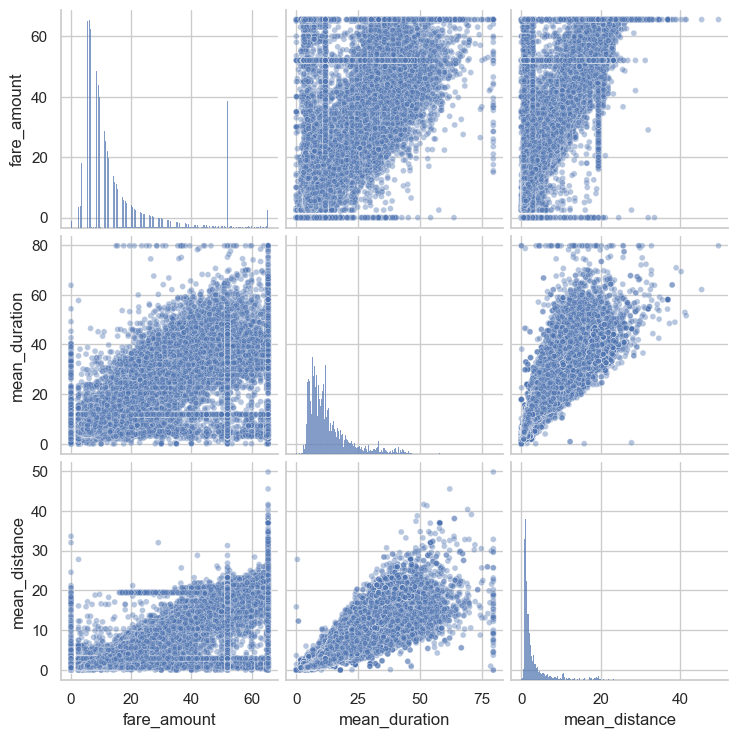

In [54]:
sns.pairplot(df2[['fare_amount', 'mean_duration', 'mean_distance']],
             plot_kws={'alpha':0.4, 'size':5},
             );

These variables all show linear correlation with each other.

### Task 7. Identify correlations

Next, code a correlation matrix to help determine most correlated variables.

In [ ]:
df2.corr(method='pearson')

,vendorid,passenger_count,fare_amount,duration,mean_distance,mean_duration,rush_hour
vendorid,1.000000,0.157132,0.025899,0.026469,0.025675,0.024349,NaN
passenger_count,0.157132,1.000000,0.021663,0.024021,0.018851,0.021866,NaN
fare_amount,0.025899,0.021663,1.000000,0.786035,0.917347,0.862339,NaN
duration,0.026469,0.024021,0.786035,1.000000,0.746135,0.816045,NaN
mean_distance,0.025675,0.018851,0.917347,0.746135,1.000000,0.914331,NaN
mean_duration,0.024349,0.021866,0.862339,0.816045,0.914331,1.000000,NaN
rush_hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualize a correlation heatmap of the data.

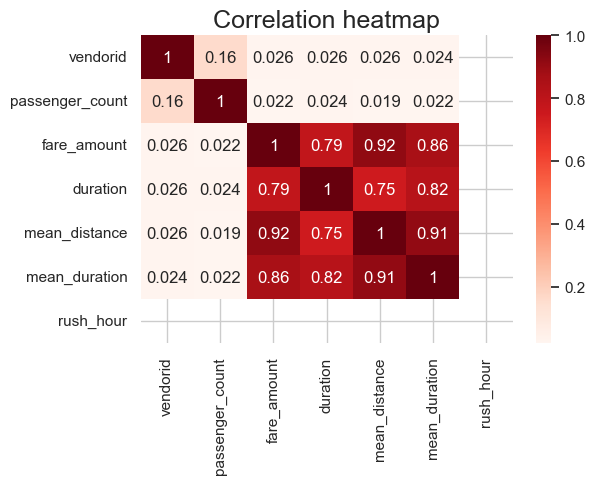

In [58]:
# Create correlation heatmap

plt.figure(figsize=(6,4))
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=18)
plt.show()

Response:
The heatmap shows that both mean_distance (r = 0.92) and mean_duration (r = 0.86) are highly correlated with the target variable fare_amount. These two predictors are also strongly correlated with each other (r = 0.91).

Highly correlated predictor variables can be problematic for linear regression if the goal is to interpret the statistical significance of each coefficient. However, if the main objective is prediction accuracy rather than inference, such multicollinearity is less of an issue.

Since the goal of this project is to predict fare_amount, it is reasonable to include both mean_distance and mean_duration in the modeling process, even though they are strongly correlated.



## **Construct**


### Task 8a. Split data into outcome variable and features

In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   vendorid         500000 non-null  int64  
 1   passenger_count  500000 non-null  int64  
 2   fare_amount      500000 non-null  float64
 3   duration         500000 non-null  float64
 4   mean_distance    500000 non-null  float64
 5   mean_duration    500000 non-null  float64
 6   rush_hour        500000 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 26.7 MB


In [62]:
# Remove the target column from the features
X = df2.drop(columns=['fare_amount'])

# Set y variable
y = df2[['fare_amount']]

# Display first few rows
X.head()

,vendorid,passenger_count,duration,mean_distance,mean_duration,rush_hour
0,1,1,6.666667,1.203791,6.289080,0
1,1,1,19.200000,2.933402,11.947595,0
2,2,3,4.166667,0.579473,3.854176,0
3,2,5,3.333333,0.286634,2.696370,0
4,2,5,1.600000,0.286634,2.696370,0


### Task 8b. Pre-process data

In [64]:
# Convert VendorID to string
X['vendorid'] = X['vendorid'].astype(str)

# Get dummies
X = pd.get_dummies(X, drop_first=True)
X.head()

,passenger_count,duration,mean_distance,mean_duration,rush_hour,vendorid_2,vendorid_4
0,1,6.666667,1.203791,6.289080,0,False,False
1,1,19.200000,2.933402,11.947595,0,False,False
2,3,4.166667,0.579473,3.854176,0,True,False
3,5,3.333333,0.286634,2.696370,0,True,False
4,5,1.600000,0.286634,2.696370,0,True,False


### Split data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [66]:
# Standardize the X variables
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
print('X_train scaled:', X_train_scaled)

X_train scaled: [[-0.49756958  0.67836229  0.27214272 ...  0.          0.78695332
  -0.10998677]
 [-0.49756958  0.34519316  0.30208218 ...  0.          0.78695332
  -0.10998677]
 [-0.49756958 -0.79868752 -0.5604469  ...  0.          0.78695332
  -0.10998677]
 ...
 [-0.49756958 -0.62575688 -0.45221276 ...  0.          0.78695332
  -0.10998677]
 [-0.49756958 -0.64479512 -0.64141544 ...  0.          0.78695332
  -0.10998677]
 [ 0.29757168 -0.23705956 -0.35750183 ...  0.          0.78695332
  -0.10998677]]


### Fit the model

Instantiate your model and fit it to the training data.

In [ ]:
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

### Task 8c. Evaluate model

### Train data



In [ ]:
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.8660107249040795
R^2: 0.8660107249040795
MAE: 1.6143193107621188
MSE: 18.438019760709224
RMSE: 4.293951532179797


### Test data



In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.862131709850558
R^2: 0.862131709850558
MAE: 1.644988469119153
MSE: 19.602909584722546
RMSE: 4.427517316140339


#### `fare_amount` outliers

Note:
The model shows strong performance on both the training and test sets, with very similar scores. This suggests that the model is not overfit and generalizes well to unseen data.

For the test data, the R² value of 0.862 means that about 86.2% of the variance in fare_amount is explained by the model.

The MAE (~1.64) indicates that, on average, the model’s predictions are off by less than $2, which is reasonable given the range of fares.

The RMSE (~4.43) shows that larger errors exist but remain relatively small compared to the overall scale of the target variable.

Overall, the model achieves a strong balance between accuracy and generalization, making it useful for predicting taxi fares.



##  **Execute**



### Task 9a. Results


In [ ]:
results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
194257,3.5,5.137240,-1.637240
396319,24.5,25.532061,-1.032061
138738,14.5,15.266460,-0.766460
66570,31.5,33.305922,-1.805922
149424,5.5,5.716131,-0.216131


### Task 9b. Visualize model results

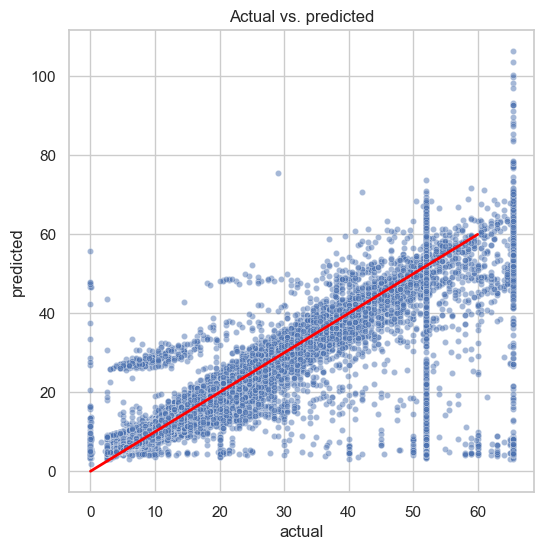

In [73]:
# Create a scatterplot to visualize `predicted` over `actual`
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([0,60], [0,60], c='red', linewidth=2)
plt.title('Actual vs. predicted');

Visualize the distribution of the `residuals` using a histogram

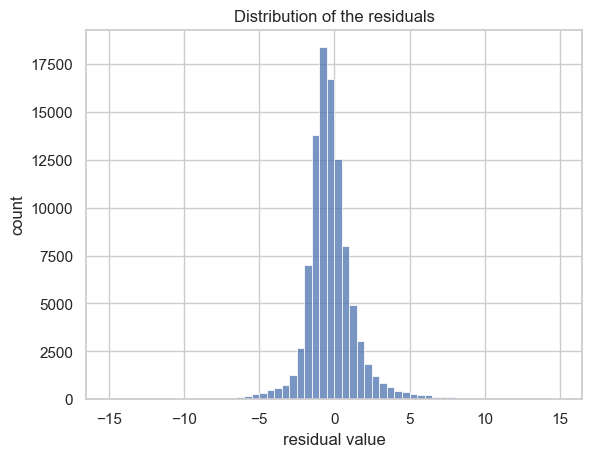

In [74]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

In [78]:
float(results['residual'].mean())


0.036763213439572756

Note: The distribution of the residuals is approximately normal and has a mean of 0.037. This mean value is very close to zero, which indicates that the model’s prediction errors are centered and unbiased. A normal distribution of residuals around zero suggests that the errors are evenly spread and that the model does not systematically over- or under-predict.

Create a scatterplot of `residuals` over `predicted`.

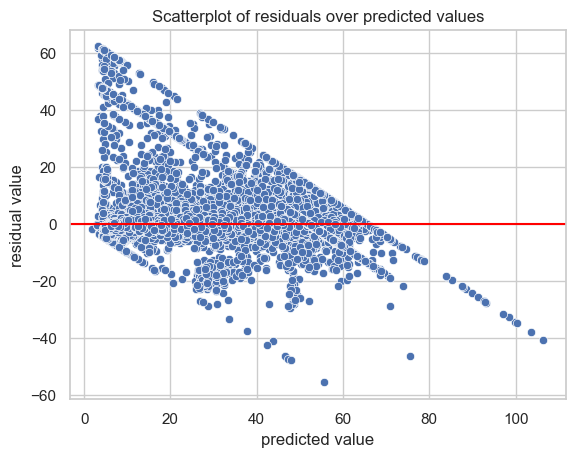

In [80]:
sns.scatterplot(x='predicted', y='residual', data=results)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

Note: The model's residuals are generally distributed above and below zero, but two strong sloping lines are visible from the upper-left to the lower-right. These correspond to the capped maximum fare of $65.50 (applied during outlier treatment) and the flat rate of $52 for JFK airport trips.

### Task 9c. Coefficients



In [81]:
# Get model coefficients
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,duration,mean_distance,mean_duration,rush_hour,vendorid_2,vendorid_4
0,0.021539,2.881292,9.216555,-0.654899,-8.881784e-16,0.021981,-0.027525


Note:
The coefficients reveal that mean_distance has the largest weight in the model’s predictions (≈ 9.22). This does not mean that every additional mile directly adds $9.22 to the fare. Since the features were standardized with StandardScaler(), the coefficients reflect changes measured in units of standard deviations, not the raw feature values.

The correct interpretation is: controlling for other variables, a one standard deviation increase in mean_distance is associated with an increase of about $9.22 in the predicted fare.

Similarly, duration has a positive effect (≈ 2.88), while mean_duration has a negative coefficient (≈ -0.65), likely due to multicollinearity among features. passenger_count and rush_hour have coefficients close to zero, indicating little direct influence after scaling.

To translate the coefficient for mean_distance back to miles:

Calculate the standard deviation of mean_distance in the X_train data.

Divide the coefficient (9.22) by this standard deviation to obtain an interpretable estimate of how much the fare increases per mile.

In [82]:
# 1. Calculate SD of `mean_distance` in X_train data
print(X_train['mean_distance'].std())

# 2. Divide the model coefficient by the standard deviation
print(7.133867 / X_train['mean_distance'].std())

4.1049141898296755
1.737884562282654


### Task 9d. Conclusion




### 1. Predict on full dataset

In [83]:
X_scaled = scaler.transform(X)
y_preds_full = lr.predict(X_scaled)

### 2. Impute ratecode 2 fare



In [91]:
# Create a new df containing just the RatecodeID col from the whole dataset
final_preds = df[['ratecodeid']].copy()

# Add a column containing all the predictions
final_preds['y_preds_full'] = y_preds_full

# Impute a prediction of 52 at all rows where RatecodeID == 2
final_preds.loc[final_preds['ratecodeid']==2, 'y_preds_full'] = 52

# Check that it worked
final_preds[final_preds['ratecodeid']==2].head()

,ratecodeid,y_preds_full
4,2,52.0
6,2,52.0
32,2,52.0
33,2,52.0
68,2,52.0


### Check performance on full dataset

In [92]:
final_preds = final_preds['y_preds_full']
print('R^2:', r2_score(y, final_preds))
print('MAE:', mean_absolute_error(y, final_preds))
print('MSE:', mean_squared_error(y, final_preds))
print('RMSE:',np.sqrt(mean_squared_error(y, final_preds)))

R^2: 0.9133000996225284
MAE: 1.3707397526009983
MSE: 12.010288432754253
RMSE: 3.4655863043292188


### final predictions with `mean_duration` and `mean_distance` columns

In [93]:
nyc_preds_means = df[['mean_duration', 'mean_distance']].copy()
nyc_preds_means['predicted_fare'] = final_preds

nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,6.289080,1.203791,7.221696
1,11.947595,2.933402,14.110095
2,3.854176,0.579473,5.399886
3,2.696370,0.286634,4.636591
4,2.696370,0.286634,52.000000
